# Optimization and Cosmological Constants

Much of life is an optimization problem. Crucially, optimization problems come not only objectives, but also constraints, sometimes *multiple* constraints. These constraints may be aligned, or may be at odds with one another. Let's talk about some examples!

In this course we've already seen one optimization technique: gradient descent. In this lecture we'll talk about optimization in general. This is important because gradient descent has its shortcoming, for instance it can get stuck in local minima and is not applicable in discrete problems. We'll talk about some other optimization techniques that can help us avoid these problems: simulated annealing and genetic algorithms.

# Bousso-Polchinski Model

We will apply these techniques to a problem that is very important in cosmology: the cosmological constant problem. This is the problem of why the cosmological constant is so small. In 2000, Bousso and Polchinski gave a new answer to this problem from string theory, that there is a discretuum of vacua with different values of the cosmological constant. This large discretuum (at least, to the extent that the toy model is accurate) ensures the existence of small cosmological constants in string theory, but it doesn't mean it's easy to *find* them. We'll use optimization techniques to find them.

In the Bousso-Polchinski model, we have 

$\Lambda = \Lambda_0 + N\cdot N$

where $N\in \mathbb{Z}^{h_{21}}$ is a vector of integers and $\Lambda_0 < 0$. There are many reasons that this is a toy model, but it gets the essential conceptual idea correct. The problem problem is that the observed cosmological constant in Nature is $10^{-120}$ in Planck units, and therefore the goal of the BP model is to find $N$ such that 

$0 < \Lambda < \epsilon$

One can think of this as adding up fluxes to lie in a shell slightly between spheres of radius $\Lambda_0$ and $\Lambda_0 + \epsilon$. We won't go all the way to $10^{-120}$, but we'll be happy to just get within a very thin shell.



In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

L0 = 200000.1293123
h21 = 1000
M = 4 # consider integer entries between -2**M and 2**M

# Random Search

This part isn't rocket science. Our vectors are 

$$N \in \mathbb{Z}^{h_{21}}$$

where the integers in the vectors are restricted to lie between $-2^M$ and $2^M$. If we pick them randomly, how do we do?

In [3]:
import numpy as np

def random_search(L0, h21, M, num_samples=10000):
    closest_vector = None
    closest_distance = float('inf')

    for _ in range(num_samples):
        N = np.random.randint(-2**M, 2**M+1, h21)
        distance = abs(np.linalg.norm(N)**2 - L0)
        if distance < closest_distance:
            closest_distance = distance
            closest_vector = N

    return closest_vector, closest_distance

N, distance = random_search(L0, h21, M)
print("Squared Euclidean norm:", np.linalg.norm(N)**2)
print("Distance:", distance)
print("Percent Error:", 100.*distance/L0)

Squared Euclidean norm: 99794.00000000001
Distance: 100206.12931229999
Percent Error: 50.1030322614583


Let's be a little more systematic.

0.48815533093905694


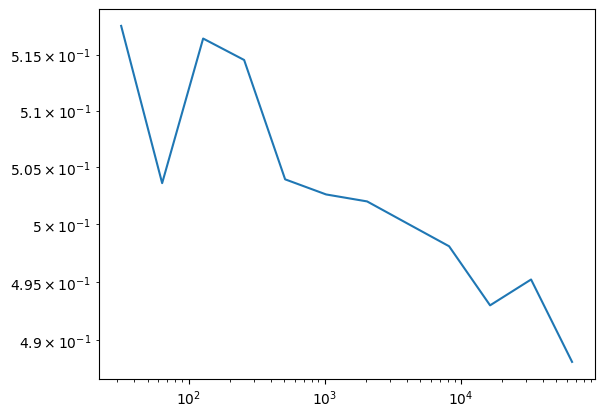

In [7]:
num_samples = [2**k for k in range(5,17)]
percent_errors = [random_search(L0, h21, M, num_samples=num_sample)[1]/L0 for num_sample in num_samples]

plt.plot(num_samples,percent_errors)
plt.yscale('log')
plt.xscale('log')
print(min(percent_errors))

To prove the point, let's let this go for *awhile*

In [8]:
N, distance = random_search(L0, h21, M, num_samples=10**6)
print('Percent Error:', 100.*distance/L0)

Percent Error: 47.464033967732995


# Simulated Annealing

We can do better. We can use a technique called simulated annealing. The basic idea is to think of the problem as some energy minimization, and then slowly cool the system, introducing fluctuation in a natural way, and hoping that the "cooling" system finds a good minimum of the energy.

In this problem, we have 
$$E(N) = |N\cdot N - \Lambda_0|$$

The basic steps in the algorithm are:
- Pick a random vector $N$ at init.
- Pick a random integer $i$.
- Do something to the $i$th element of $N$, call this $N'$.
- If $E(N) < E(N')$, then accept the new vector.
- If $E(N) > E(N')$, then accept the new vector with probability $e^{-\frac{E(N') - E(N)}{T}}$.
- Make $T$ smaller next time around.
- Iterate.

In [9]:
import numpy as np 

def simulated_annealing(L0, h21, M, max_iters=10000, initial_temp=1000, cooling_rate=0.99):
    current_vector = np.random.randint(-2**M, 2**M+1, h21)
    current_distance = abs(np.linalg.norm(current_vector)**2 - L0)

    best_vector = np.copy(current_vector)
    best_distance = current_distance 

    temperature = initial_temp 

    for i in range(max_iters):
        new_vector = np.copy(current_vector)
        index_to_change = np.random.choice(h21)
        change = np.random.randint(-2,3)
        new_vector[index_to_change] += change
        new_vector = np.clip(new_vector, -2**M, 2**M)

        new_distance = abs(np.linalg.norm(new_vector)**2 - L0)

        if new_distance < best_distance:
            best_vector = np.copy(new_vector)
            best_distance = new_distance 

        if new_distance < current_distance or np.random.rand() < np.exp((current_distance-new_distance)/temperature):
            current_vector = np.copy(new_vector)
            current_distance = new_distance

        temperature *= cooling_rate
    
    return best_vector, best_distance

N, distance = simulated_annealing(L0, h21, M)
print("Vector N:", N)
print("Squared Euclidean norm:", np.linalg.norm(N)**2)
print("Distance:", distance)
print("Percent Error:", 100.*distance/L0)

Vector N: [ 16  10 -16 -16 -10  -9  16   7 -16 -15  11  12  16 -16  -6   7  14  15
  10 -10   9  -8  16  12  16  -7  16  16 -16  10 -16   9   8 -16  16 -16
  16 -16  16  12 -13 -13  15 -16  -9 -16  -8 -11 -16  15 -14  16 -15  16
  13  16  16 -12 -10 -12  10 -16   8  14 -15  16  15 -16  16  16 -16 -16
  13 -16  -7  16  14  16  13  16  16 -16   5   8   6  14  16 -11  -7  -8
 -12  12  16 -11  14 -16  -9 -16 -16  10  16 -10 -12 -11  16  16 -16 -16
  16 -14  16 -10 -10  16  -7  14 -16  16 -16 -10  16  15   3  15 -16 -16
 -16 -12   8  -4 -10  13  16  15  16  16  14  16  16 -16   8  16 -10  13
 -10 -16 -16 -14 -16  16  10 -12 -14  15 -16  11 -12 -16 -16 -16  14  16
  14  -8   8  16  16 -16  11 -11 -16 -16 -14  12   5  14  10  -9  16  16
   8  16  -9 -16 -16  -6  16  16 -16  11  12  14  14  16   3   5 -16  14
 -15 -16 -16  -2  16  16   8 -16  -9  11 -16  16  16  16 -12  -3  -6 -11
  -9 -15 -13  11 -16 -16 -16 -16  -5 -15   8  16  16 -16  16  -7  10 -16
 -16 -16  16  16 -16 -15  -4  -8  10  13 

Already much better in .1s than 10s of seconds with random search. Let's crank up the number of iterations and cool more slowly.

In [10]:
N, distance = simulated_annealing(L0, h21, M, max_iters = 1000000, cooling_rate=0.999)
# print("Vector N:", N)
print("Squared Euclidean norm:", np.linalg.norm(N)**2)
print("Distance:", distance)
print("Percent Error:", 100.*distance/L0)

/var/folders/wz/s4rx21_137g79thgtc1s1k3m0000gn/T/ipykernel_48061/2080265195.py:25: RuntimeWarning: overflow encountered in scalar divide
  if new_distance < current_distance or np.random.rand() < np.exp((current_distance-new_distance)/temperature):


Squared Euclidean norm: 200000.0
Distance: 0.129312300006859
Percent Error: 6.465610819927919e-05


In [11]:
N

array([-14,  16, -16,   6, -15, -10, -16,  16,  16,  -9,  13,  16,  16,
       -16,  16, -11, -16,  16, -16, -16, -15,  16, -16, -16,  16,   9,
        16,   9,  16,  16, -10,   4, -11,  -6, -16, -16, -16,  16, -11,
       -14, -12, -16,  16,  10, -16,   8,  16,  16,  16,  -7,  -6,  16,
       -11,   9,  16,  12, -15, -16,  -8, -16,  14,   9,   5,  16,  16,
        13,  16,  16,  16,  16,  16, -14, -13,  -8,  13, -16,   7,  16,
       -10, -11,   5,  -6,  16,  -4,  15,  16,  16, -10,   9, -10,  -5,
       -10, -13, -10, -16, -16,  16, -14,  10, -16, -16,  12,  16, -16,
       -16, -16, -16,  11, -16, -16, -16,  16, -16, -12,  -8,  16, -16,
        16,  12,  16, -16, -16,  11,  16,  16,  -6, -16, -15, -16,  12,
       -16,  16,  16,  16,  16, -12,  16, -16,  11,  16,  -9, -15,  13,
        16, -16,  16,  16, -16, -16, -16,   4,   2, -16,  16,  16,  16,
        -8, -10,  16,  16,  16,  10, -16,  16, -16, -15,  16, -16,  11,
       -16, -10, -16,   8, -13, -16,  16,   6,  16,  10, -16,  1

# Genetic Algorithms

In [12]:
import numpy as np

def genetic_algorithm(L0, h21, M, population_size=100, generations=10000, mutation_rate=0.1):
    population = np.random.randint(-2**M, 2**M+1, (population_size, h21))

    for generation in range(generations):
        fitness = np.array([1/abs(np.linalg.norm(ind)**2-L0) for ind in population])
        parent_indices = fitness.argsort()[-2:]
        parent1, parent2 = population[parent_indices]

        point = np.random.randint(1,h21-1)
        child = np.concatenate((parent1[:point], parent2[point:]))

        if np.random.rand() < mutation_rate:
            mutation_index = np.random.choice(h21)
            mutation_value = np.random.randint(-2**M, 2**M+1)
            child[mutation_index] = mutation_value

        worst_index = fitness.argmin()
        population[worst_index] = child

    fitness = np.array([1/abs(np.linalg.norm(ind)**2-L0) for ind in population])
    best_index = np.argmax(fitness)
    best_vector = population[best_index]
    distance = abs(np.linalg.norm(best_vector)**2 - L0)

    return best_vector, distance 

N, distance = genetic_algorithm(L0, h21, M)
print("Squared Euclidean norm:", np.linalg.norm(N)**2)
print("Distance:", distance)
print("Percent Error:", 100.*distance/L0)

Squared Euclidean norm: 133611.0
Distance: 66389.1293123
Percent Error: 33.19454319383637


But don't you know that evolution takes time?

In [14]:
N, distance = genetic_algorithm(L0, h21, M, generations=100000, mutation_rate=0.1)
print("Squared Euclidean norm:", np.linalg.norm(N)**2)
print("Distance:", distance)
print("Percent Error:", 100.*distance/L0)

Squared Euclidean norm: 200004.0
Distance: 3.870687699993141
Percent Error: 0.0019353425986785569


# Sample and Bump

Alternatively, we can try sampling a random unit vector, putting it on the sphere, and bumping it to an integer. How does this work?

Ok, so this worked better than expected. What are some downsides of this technique?